In [28]:
import numpy as np
import sys, pickle, csv
import cv2

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, auc, roc_curve

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as VGG19_preprocess
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as InceptionV3_preprocess
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as ResNet50V2_preprocess
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as Xception_preprocess

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # memory increase is needed before starting program
        print(e)


In [2]:
# load dataset

image_dim = 384


dpath_original = 'D:kvasir_cls/kvasir-dataset-v2'
dpath_preprocess = dpath_original+'_preprocess'
class_list = ['esophagitis', 'dyed-lifted-polyps', 'dyed-resection-margins', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']


with open(dpath_preprocess +'/kvasir_cls_'+str(image_dim)+'no_polyp'+'.pickle', 'rb') as f:
    [X,Y] = pickle.load(f)
    print(X.shape, Y.shape)

with open(dpath_preprocess +'/kvasir_cls_'+str(image_dim)+'polyp' + '.pickle', 'rb') as w:
    [X_polyp, Y_polyp] =  pickle.load(w)
    print(X_polyp.shape, Y_polyp.shape)

assert np.max(X) == 255
assert np.min(X) == 0
assert np.max(X_polyp) == 255
assert np.min(X_polyp) == 0

# rest dataset split
X_trnval_no, X_tst_no, Y_trnval_no, Y_tst_no = train_test_split(X, Y, test_size = 1.5 / 10, random_state = 27407, stratify = Y)
X_trn_no, X_val_no, Y_trn_no, Y_val_no = train_test_split(X_trnval_no, Y_trnval_no, test_size = 1.5 / 8.5, random_state = 27407, stratify = Y_trnval_no)

# polyp split
X_trnval_polyp, X_tst_polyp, Y_trnval_polyp, Y_tst_polyp = train_test_split(X_polyp, Y_polyp, test_size = 1.5 / 10, random_state = 27407)
X_trn_polyp, X_val_polyp, Y_trn_polyp, Y_val_polyp = train_test_split(X_trnval_polyp, Y_trnval_polyp, test_size = 1.5 / 8.5, random_state = 27407)

# concatenation and onehot encoding
enc = OneHotEncoder(sparse=False)

X_trn = np.concatenate((X_trn_no, X_trn_polyp), axis=0)
Y_trn = np.concatenate((Y_trn_no, Y_trn_polyp))
Y_trn = enc.fit_transform(Y_trn)

n_class = Y_trn.shape[1]
print("total class number: ", n_class)

X_val = np.concatenate((X_val_no, X_val_polyp), axis=0)
Y_val = np.concatenate((Y_val_no, Y_val_polyp), axis=0)
Y_val = enc.fit_transform(Y_val)

X_tst = np.concatenate((X_tst_no, X_tst_polyp), axis=0)
Y_tst = np.concatenate((Y_tst_no, Y_tst_polyp), axis=0)
Y_tst = enc.fit_transform(Y_tst)


print('trn.shape', X_trn.shape, Y_trn.shape)
print('val.shape', X_val.shape, Y_val.shape)
print('tst.shape', X_tst.shape, Y_tst.shape)

with open("D:/"+"kvasir" + "/kvasir_" + str(image_dim) + '.pickle', 'rb') as q:
    [X_seg, Y_seg] = pickle.load(q)
    print(X_seg.shape, Y_seg.shape)
    
Y_seg = np.expand_dims(Y_seg, 3)

assert np.max(X_seg) == 255
assert np.min(X_seg) == 0
assert np.max(Y_seg) == 1
assert np.min(Y_seg) == 0

# polyp split
X_trnval_s, X_tst_s, Y_trnval_s, Y_tst_s = train_test_split(X_seg, Y_seg, test_size = 1.5 / 10, random_state = 27407)
X_trn_s, X_val_s, Y_trn_s, Y_val_s = train_test_split(X_trnval_s, Y_trnval_s, test_size = 1.5 / 8.5, random_state = 27407)


(7000, 384, 384, 3) (7000, 1)
(1000, 384, 384, 3) (1000, 1)
total class number:  8
trn.shape (5600, 384, 384, 3) (5600, 8)
val.shape (1200, 384, 384, 3) (1200, 8)
tst.shape (1200, 384, 384, 3) (1200, 8)
(1000, 384, 384, 3) (1000, 384, 384)


In [37]:
# pred_index = 7 for polyp class
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(np.expand_dims(img_array, axis=0).astype('float32')) # uint8 -> float32 
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [38]:
def gradcam_evaluation(gradcam_heatmap, Y_tst):
    gradcam_heatmap = cv2.resize(gradcam_heatmap, (image_dim, image_dim))
    fpr, tpr, _ = roc_curve(Y_tst.ravel(), gradcam_heatmap.ravel())
    roc_auc = auc(fpr, tpr)
    return roc_auc

In [34]:
def cam_evaluation(model, X_tst, Y_tst):
    auroc_list = []
    for i in range(len(X_tst)):
        heatmap = make_gradcam_heatmap(X_tst[i], model, last_conv_layer_name)
        auroc_list.append(gradcam_evaluation(heatmap, Y_tst[i]))
    return sum(auroc_list) / len(auroc_list)

In [4]:
base_model = Xception(weights = 'imagenet', pooling='avg', include_top = False)
preprocess_func = Xception_preprocess

predictions = Dense(8, activation='softmax')(base_model.output)

model = Model(inputs = base_model.input, outputs = predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [5]:
last_conv_layer_name = "block14_sepconv2_act"

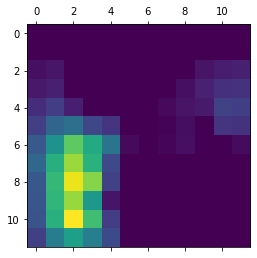

In [26]:
heatmap = make_gradcam_heatmap(X_trn_s[0], model, last_conv_layer_name)
plt.matshow(heatmap)
plt.show()

In [33]:
a = [1,2,3]
sum(a)

6

In [36]:
result = cam_evaluation(model, X_tst_s, Y_tst_s)
print(result)

0.5888926746759715


In [ ]:
def cam_evaluation(model, X_tst, Y_tst):
    auroc_list = []
    for i in range(len(X_tst)):
        heatmap = make_gradcam_heatmap(X_tst[i], model, last_conv_layer_name)
        auroc_list.append(gradcam_evaluation(heatmap, Y_tst[i]))
    return sum(auroc_list) / len(auroc_list)
        
        

In [29]:
gradcam_evaluation(heatmap, Y_trn_s[0])

0.3818862532884949

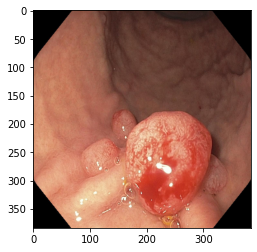

In [30]:
plt.imshow(X_trn_s[0])

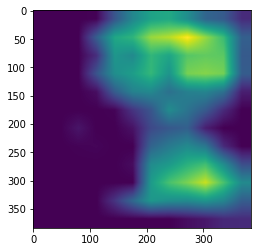

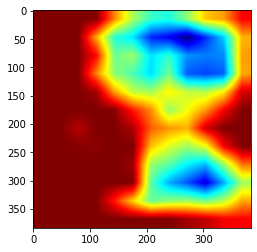

In [17]:
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
plt.imshow(heatmap)

In [ ]:
def gradcam_evaluation(gradcam_heatmap, Y_tst):
    gradcam_heatmap = cv2.resize(gradcam_heatmap, (image_dim, image_dim))
    fpr, tpr, _ = roc_curve(Y_tst.ravel(), gradcam_heatmap.ravel())
    roc_auc = auc(fpr, tpr)
    return roc_auc